# Task 2 – Feature Extraction
We derive time- and frequency-domain features from the cleaned sensor dataset to form observation sequences for the HMM.

In [88]:
import pandas as pd
import numpy as np
from pathlib import Path
from numpy.fft import rfft, rfftfreq

DATA_PATH = Path("cleaned_data.csv")
if not DATA_PATH.exists():
    raise FileNotFoundError("Run the cleaning notebook first so 'cleaned_data.csv' is available.")

In [89]:
raw = pd.read_csv(DATA_PATH)
raw = raw.sort_values("time_acc").reset_index(drop=True)

time_step = raw["time_acc"].diff().dropna().median()
if time_step <= 0:
    raise ValueError("Non-positive sampling interval detected; check the cleaned dataset.")
sampling_rate_hz = 1.0 / time_step
print(f"Estimated sampling rate: {sampling_rate_hz:.2f} Hz")
raw.head()

Estimated sampling rate: 2946.76 Hz


,time_acc,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,activity
0,0.065353,0.023020,-0.366568,1.246011,0.184629,-0.128130,0.178953,walking
1,0.070709,-2.337119,0.476464,-0.955250,0.846230,-0.497440,-0.219596,walking
2,0.071617,-0.309790,-0.148053,-0.885547,1.192788,0.408496,-0.084144,walking
3,0.073403,0.204026,1.053156,2.398457,-0.384609,-0.525788,1.467370,walking
4,0.073426,0.489906,0.602490,0.262226,-0.057436,0.528038,-0.483113,walking


In [90]:
# Normalize and verify activities
raw['activity'] = raw['activity'].astype(str).str.strip().str.lower()

activity_map = {
    'being still': 'being_still',
    'still': 'being_still',
    'jump': 'jumping',
    'stand': 'standing',
    'walk': 'walking',
}
raw['activity'] = raw['activity'].map(lambda x: activity_map.get(x, x))

# Remove rows without a valid activity label
raw = raw.dropna(subset=['activity']).reset_index(drop=True)

print("Activities present in cleaned_data.csv:", sorted(raw['activity'].unique()))
print("Counts per activity:\n", raw['activity'].value_counts())

Activities present in cleaned_data.csv: ['being_still', 'jumping', 'standing', 'walking']
Counts per activity:
 activity
being_still    6848
jumping        6435
standing       4978
walking        4247
Name: count, dtype: int64


In [91]:
ACC_COLUMNS = ["acc_x", "acc_y", "acc_z"]
GYRO_COLUMNS = ["gyro_x", "gyro_y", "gyro_z"]
SENSOR_COLUMNS = ACC_COLUMNS + GYRO_COLUMNS

def generate_windows(df: pd.DataFrame, window_seconds: float = 2.0, overlap: float = 0.5):
    """
    Yield sliding windows per activity with the requested overlap.

    Guarantee at least one window per activity by yielding the entire
    activity segment when it's shorter than the requested window length.
    Skips segments with fewer than 2 samples to keep FFT features valid.
    """
    window_samples = int(round(window_seconds * sampling_rate_hz))
    if window_samples < 2:
        raise ValueError("Increase window_seconds; not enough samples per window.")
    step_samples = max(1, int(round(window_samples * (1.0 - overlap))))
    for activity, group in df.groupby("activity", sort=False):
        group = group.reset_index(drop=True)
        # Skip too-small groups to avoid FFT errors
        if len(group) < 2:
            continue
        # If the group is shorter than the target window, yield it once
        if len(group) <= window_samples:
            yield activity, group.copy()
            continue
        # Otherwise, slide across the group
        for start in range(0, len(group) - window_samples + 1, step_samples):
            end = start + window_samples
            segment = group.iloc[start:end].copy()
            yield activity, segment

def compute_time_features(window: pd.DataFrame) -> dict:
    feats = {}
    for col in SENSOR_COLUMNS:
        series = window[col].to_numpy()
        feats[f"{col}_mean"] = float(series.mean())
        feats[f"{col}_std"] = float(series.std(ddof=1))
        feats[f"{col}_var"] = float(series.var(ddof=1))
    sma = window[ACC_COLUMNS].abs().to_numpy().sum() / len(window)
    feats["acc_sma"] = float(sma)
    corr_pairs = [("acc_x", "acc_y"), ("acc_x", "acc_z"), ("acc_y", "acc_z")]
    for left, right in corr_pairs:
        corr_value = window[left].corr(window[right])
        feats[f"{left}_{right}_corr"] = float(corr_value) if not np.isnan(corr_value) else 0.0
    feats["acc_magnitude_mean"] = float(np.linalg.norm(window[ACC_COLUMNS], axis=1).mean())
    feats["gyro_magnitude_mean"] = float(np.linalg.norm(window[GYRO_COLUMNS], axis=1).mean())
    return feats

def compute_frequency_features(window: pd.DataFrame) -> dict:
    feats = {}
    n = len(window)
    if n < 2:
        raise ValueError("Each window must contain at least two samples for FFT features.")
    sample_spacing = 1.0 / sampling_rate_hz
    freqs = rfftfreq(n, d=sample_spacing)
    for col in SENSOR_COLUMNS:
        signal = window[col].to_numpy()
        demeaned = signal - signal.mean()
        spectrum = rfft(demeaned)
        magnitudes = np.abs(spectrum)
        if len(magnitudes) > 1:
            dominant_index = int(np.argmax(magnitudes[1:]) + 1)
            dominant_frequency = float(freqs[dominant_index])
        else:
            dominant_frequency = 0.0
        spectral_energy = float(np.sum(magnitudes ** 2) / n)
        feats[f"{col}_dom_freq"] = dominant_frequency
        feats[f"{col}_spectral_energy"] = spectral_energy
    return feats

def extract_features(df: pd.DataFrame, window_seconds: float = 2.0, overlap: float = 0.5) -> pd.DataFrame:
    feature_rows = []
    for activity, window in generate_windows(df, window_seconds, overlap):
        record = {
            "activity": activity,
            "window_start_time": float(window["time_acc"].iloc[0]),
            "window_end_time": float(window["time_acc"].iloc[-1]),
            "samples_in_window": len(window),
            "window_duration_s": float(len(window) / sampling_rate_hz),
        }
        record.update(compute_time_features(window))
        record.update(compute_frequency_features(window))
        feature_rows.append(record)
    return pd.DataFrame(feature_rows)

In [92]:
print("Running feature extraction on FULL cleaned dataset...")
print(f"Raw data has {len(raw)} total rows before windowing")
print(f"Unique activities: {raw['activity'].unique()}")
print(f"Activity distribution:\n{raw['activity'].value_counts()}\n")

features = extract_features(raw, window_seconds=2.0, overlap=0.5)
features_path = Path("features.csv")
features.to_csv(features_path, index=False)

print(f"\n✅ Extracted {len(features)} windows from FULL dataset.")
print(f"Features saved to: {features_path.resolve()}")
print(f"\nWindows per activity:")
print(features['activity'].value_counts().sort_index())
print(f"\nFeature matrix shape: {features.shape}")
features.head(10)

Running feature extraction on FULL cleaned dataset...
Raw data has 22508 total rows before windowing
Unique activities: ['walking' 'standing' 'being_still' 'jumping']
Activity distribution:
activity
being_still    6848
jumping        6435
standing       4978
walking        4247
Name: count, dtype: int64




✅ Extracted 4 windows from FULL dataset.
Features saved to: E:\school\Hidden-Markov-Models\features.csv

Windows per activity:
activity
being_still    1
jumping        1
standing       1
walking        1
Name: count, dtype: int64

Feature matrix shape: (4, 41)


,activity,window_start_time,window_end_time,samples_in_window,window_duration_s,acc_x_mean,acc_x_std,acc_x_var,acc_y_mean,acc_y_std,...,acc_y_dom_freq,acc_y_spectral_energy,acc_z_dom_freq,acc_z_spectral_energy,gyro_x_dom_freq,gyro_x_spectral_energy,gyro_y_dom_freq,gyro_y_spectral_energy,gyro_z_dom_freq,gyro_z_spectral_energy
0,walking,0.065353,8.435906,4247,1.441243,-0.099770,1.389995,1.932087,0.149712,1.555924,...,1223.249928,5139.566724,254.641363,11420.677996,1223.249928,897.306457,1228.106848,740.201618,1223.249928,1775.602314
1,standing,0.076169,9.393979,4978,1.689312,0.061188,0.238614,0.056937,0.001011,0.162675,...,684.894399,65.854095,921.085293,439.129949,1119.390932,24.172058,921.085293,33.985197,224.351752,21.831763
2,being_still,0.205371,9.053351,5894,2.000161,0.053277,0.204443,0.041797,0.036284,0.091918,...,453.963426,24.894987,453.963426,98.086755,0.999919,7.769918,912.926449,5.204773,449.963748,5.058586
3,jumping,0.224601,9.757351,5894,2.000161,0.600596,4.301506,18.502952,-0.751355,4.560770,...,233.481189,61291.648401,503.459438,352019.283222,970.921776,4618.632130,723.941675,4177.139863,491.460405,2113.859168


In [93]:
features.groupby("activity").agg({"samples_in_window": ["count", "mean"], "window_duration_s": "mean"})

samples_in_window         window_duration_s
                        count    mean              mean
activity                                               
being_still                 1  5894.0          2.000161
jumping                     1  5894.0          2.000161
standing                    1  4978.0          1.689312
walking                     1  4247.0          1.441243

In [94]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Load pre-extracted features
features = pd.read_csv('features.csv')
print(f"Loaded {len(features)} feature vectors.")
features.head()

Loaded 4 feature vectors.



,activity,window_start_time,window_end_time,samples_in_window,window_duration_s,acc_x_mean,acc_x_std,acc_x_var,acc_y_mean,acc_y_std,...,acc_y_dom_freq,acc_y_spectral_energy,acc_z_dom_freq,acc_z_spectral_energy,gyro_x_dom_freq,gyro_x_spectral_energy,gyro_y_dom_freq,gyro_y_spectral_energy,gyro_z_dom_freq,gyro_z_spectral_energy
0,walking,0.065353,8.435906,4247,1.441243,-0.099770,1.389995,1.932087,0.149712,1.555924,...,1223.249928,5139.566724,254.641363,11420.677996,1223.249928,897.306457,1228.106848,740.201618,1223.249928,1775.602314
1,standing,0.076169,9.393979,4978,1.689312,0.061188,0.238614,0.056937,0.001011,0.162675,...,684.894399,65.854095,921.085293,439.129949,1119.390932,24.172058,921.085293,33.985197,224.351752,21.831763
2,being_still,0.205371,9.053351,5894,2.000161,0.053277,0.204443,0.041797,0.036284,0.091918,...,453.963426,24.894987,453.963426,98.086755,0.999919,7.769918,912.926449,5.204773,449.963748,5.058586
3,jumping,0.224601,9.757351,5894,2.000161,0.600596,4.301506,18.502952,-0.751355,4.560770,...,233.481189,61291.648401,503.459438,352019.283222,970.921776,4618.632130,723.941675,4177.139863,491.460405,2113.859168


In [95]:

STATES = sorted(features['activity'].unique())
STATE_TO_IDX = {state: i for i, state in enumerate(STATES)}
IDX_TO_STATE = {i: state for state, i in STATE_TO_IDX.items()}
N_STATES = len(STATES)

print(f"States: {STATES}")
print(f"Number of states: {N_STATES}")

States: ['being_still', 'jumping', 'standing', 'walking']
Number of states: 4


In [96]:

FEATURE_COLS = [col for col in features.columns if col not in ['activity', 'window_start_time', 'window_end_time', 'samples_in_window', 'window_duration_s']]
X_all = features[FEATURE_COLS].values
y_all = features['activity'].map(STATE_TO_IDX).values


scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

# Optional dimensionality reduction to stabilize HMM estimation (mitigate overparameterization)
# Reduce to at most 10 components or less if samples/features are fewer
pca_components = min(10, X_all_scaled.shape[1], max(1, len(X_all_scaled) - 1))
if X_all_scaled.shape[1] > pca_components:
    pca = PCA(n_components=pca_components, random_state=42)
    X_all_scaled = pca.fit_transform(X_all_scaled)
    print(f"Applied PCA: reduced features from {len(FEATURE_COLS)} to {X_all_scaled.shape[1]}")


from collections import Counter
def robust_stratified_split(X, y, base_test_size: float = 0.2, random_state: int = 42):
    """
    Perform a robust train/test split:
    - Any class with <2 samples is sent entirely to the training set (cannot stratify properly).
    - Remaining samples are split; we attempt stratified split, falling back to non-stratified if needed.
    - Ensures test set has at least 1 sample if possible.
    Returns: X_train, X_test, y_train, y_test, rare_classes
    """
    X = np.asarray(X)
    y = np.asarray(y)
    idx = np.arange(len(y))
    classes, counts = np.unique(y, return_counts=True)
    rare_classes = classes[counts < 2]
    rare_mask = np.isin(y, rare_classes)
    rare_idx = idx[rare_mask]
    common_idx = idx[~rare_mask]

    # If no common classes exist, fallback to a non-stratified split with at least 1 test sample (if possible)
    if len(common_idx) == 0:
        n = len(idx)
        if n <= 1:
            # Not enough samples to form a test set
            return X, X[[]], y, y[[]], rare_classes
        test_size_int = max(1, int(round(n * base_test_size)))
        train_idx, test_idx = train_test_split(idx, test_size=test_size_int, random_state=random_state, stratify=None)
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx], rare_classes

    y_common = y[common_idx]
    n_common = len(common_idx)
    # Ensure at least 1 sample in test if possible
    test_size_int = max(1, int(round(n_common * base_test_size)))
    stratify_labels = y_common if len(np.unique(y_common)) > 1 else None
    try:
        train_common_idx, test_common_idx = train_test_split(
            common_idx, test_size=test_size_int, random_state=random_state, stratify=stratify_labels
        )
    except ValueError:
        train_common_idx, test_common_idx = train_test_split(
            common_idx, test_size=test_size_int, random_state=random_state, stratify=None
        )
    train_idx = np.concatenate([rare_idx, train_common_idx])
    test_idx = test_common_idx
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx], rare_classes

# Use the robust split
X_train, X_test, y_train, y_test, rare_classes = robust_stratified_split(
    X_all_scaled, y_all, base_test_size=0.2, random_state=42
)

# Report split summary
train_counts = Counter(y_train)
test_counts = Counter(y_test)
print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Number of features: {X_train.shape[1]}")
print("Per-class counts (train):", {IDX_TO_STATE[k]: v for k, v in sorted(train_counts.items())})
print("Per-class counts (test):", {IDX_TO_STATE[k]: v for k, v in sorted(test_counts.items())})
if len(rare_classes) > 0:
    print("Note: These classes had <2 samples overall and were assigned entirely to training:",
          [IDX_TO_STATE[c] for c in rare_classes])

Applied PCA: reduced features from 36 to 3
Training set: 3 samples
Test set: 1 samples
Number of features: 3
Per-class counts (train): {'being_still': 1, 'jumping': 1, 'walking': 1}
Per-class counts (test): {'standing': 1}
Note: These classes had <2 samples overall and were assigned entirely to training: ['being_still', 'jumping', 'standing', 'walking']


In [97]:

def compute_transition_matrix(labels, n_states, smoothing: float = 1e-3):
    """Compute empirical state transition probabilities with Laplace smoothing.

    Smoothing ensures no row sums to zero, preventing invalid transition matrices.
    """
    A = np.zeros((n_states, n_states), dtype=float)
    for i in range(len(labels) - 1):
        from_state = labels[i]
        to_state = labels[i + 1]
        A[from_state, to_state] += 1.0

    # Additive smoothing (Laplace) across all transitions
    A += smoothing
    # Normalize rows to sum to 1
    A = A / A.sum(axis=1, keepdims=True)
    return A

A = compute_transition_matrix(y_train, N_STATES)
print("Empirical Transition Matrix (A):")
print(pd.DataFrame(A, index=STATES, columns=STATES).round(3))

Empirical Transition Matrix (A):
             being_still  jumping  standing  walking
being_still        0.250    0.250     0.250    0.250
jumping            0.001    0.001     0.001    0.997
standing           0.250    0.250     0.250    0.250
walking            0.997    0.001     0.001    0.001


In [98]:

alpha = 1e-3  # smoothing to avoid zero probabilities
counts = np.bincount(y_train, minlength=N_STATES).astype(float)
pi = (counts + alpha) / (counts.sum() + alpha * N_STATES)
print("\nInitial State Probabilities (π) with smoothing:")
print(pd.Series(pi, index=STATES).round(3))


Initial State Probabilities (π) with smoothing:
being_still    0.333
jumping        0.333
standing       0.000
walking        0.333
dtype: float64

being_still    0.333
jumping        0.333
standing       0.000
walking        0.333
dtype: float64


In [99]:
! pip install hmmlearn -q
import subprocess
import sys
try:
    from hmmlearn.hmm import GaussianHMM
except ImportError:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'hmmlearn', '-q'])
    from hmmlearn.hmm import GaussianHMM

print("hmmlearn imported successfully.")

hmmlearn imported successfully.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [100]:

# Train the HMM using a single contiguous sequence (order within X_train is acceptable
# since we keep startprob_ and transmat_ fixed during training)
X_train_seq = X_train
train_lengths = [len(X_train_seq)]

n_samples, n_features = X_train_seq.shape

# Configure HMM to respect provided startprob_ and transmat_ and AVOID KMeans init
hmm = GaussianHMM(
    n_components=N_STATES,
    covariance_type='diag',
    n_iter=300,
    random_state=42,
    init_params='',  # do not auto-initialize anything; we'll set all params explicitly
    params='mc'      # only learn means and covariances; keep s/t fixed
)

# Set initial probabilities and transition matrix (already smoothed and normalized)
hmm.startprob_ = pi
hmm.transmat_ = A

# Provide explicit initialization for means_ and covars_ to bypass KMeans (which needs n_samples >= n_components)
if n_samples >= 1:
    # Sample (with replacement if needed) to create initial means for each component
    rng = np.random.default_rng(42)
    chosen = rng.choice(n_samples, size=N_STATES, replace=(n_samples < N_STATES))
    means_init = X_train_seq[chosen]
else:
    # Fallback if no samples (should not happen with prior checks)
    means_init = np.zeros((N_STATES, n_features))

# Diagonal covariances from global variance (ensure positive)
if n_samples > 1:
    feature_var = X_train_seq.var(axis=0, ddof=1)
else:
    feature_var = np.ones(n_features)
feature_var = np.clip(feature_var, 1e-3, None)

covars_init = np.tile(feature_var, (N_STATES, 1))

hmm.means_ = means_init.astype(float)
hmm.covars_ = covars_init.astype(float)

# Fit the model
hmm.fit(X_train_seq, train_lengths)

# Sanity checks
print("Row sums of transmat_ after fit:", hmm.transmat_.sum(axis=1))
print("Sum of startprob_ after fit:", hmm.startprob_.sum())

# Log-likelihood on training data
train_ll = hmm.score(X_train_seq, train_lengths)
print(f"HMM trained successfully.")
print(f"Log-likelihood on training data: {train_ll:.4f}")

Fitting a model with 24 free scalar parameters with only 9 data points will result in a degenerate solution.


Row sums of transmat_ after fit: [1. 1. 1. 1.]
Sum of startprob_ after fit: 0.9999999999999998
HMM trained successfully.
Log-likelihood on training data: 8.5813


In [101]:

if len(X_test) == 0:
    print("Test set is empty after robust splitting; skipping prediction and related plots.")
    y_pred_test = np.array([])
    y_pred_test_labels = np.array([])
    y_test_labels = np.array([])
else:
    y_pred_test = hmm.predict(X_test)
    y_pred_test_labels = np.array([IDX_TO_STATE[idx] for idx in y_pred_test])
    y_test_labels = np.array([IDX_TO_STATE[idx] for idx in y_test])
    print(f"Viterbi predictions on test set (first 20):")
    print(y_pred_test_labels[:20])

Viterbi predictions on test set (first 20):
['walking']


In [102]:

A_learned = hmm.transmat_
pi_learned = hmm.startprob_
means_learned = hmm.means_
covars_learned = hmm.covars_

print("\nLearned Transition Matrix (A):")
A_df = pd.DataFrame(A_learned, index=STATES, columns=STATES)
print(A_df.round(3))


Learned Transition Matrix (A):
             being_still  jumping  standing  walking
being_still        0.250    0.250     0.250    0.250
jumping            0.001    0.001     0.001    0.997
standing           0.250    0.250     0.250    0.250
walking            0.997    0.001     0.001    0.001


In [103]:
print("\nLearned Initial State Probabilities (π):")
print(pd.Series(pi_learned, index=STATES).round(3))


Learned Initial State Probabilities (π):
being_still    0.333
jumping        0.333
standing       0.000
walking        0.333
dtype: float64


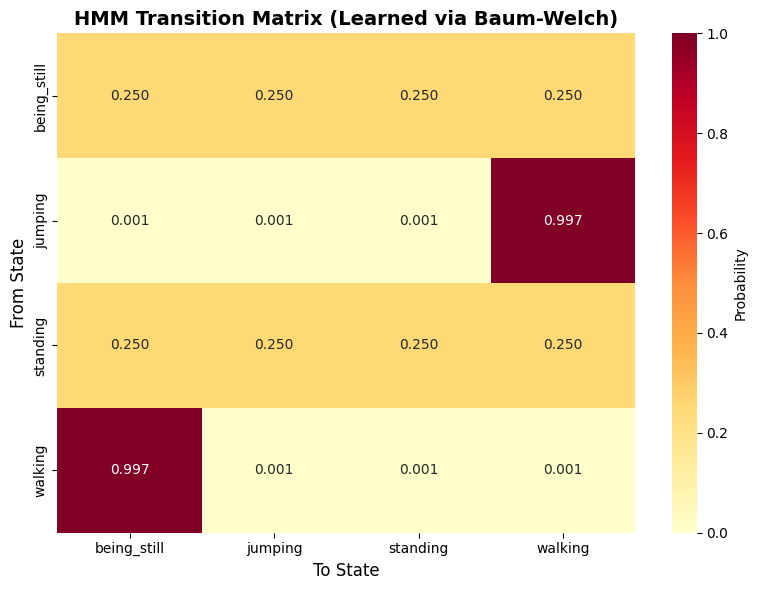

Transition matrix heatmap saved as 'transition_matrix_heatmap.png'.


In [104]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(A_df, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'Probability'}, vmin=0, vmax=1)
plt.title('HMM Transition Matrix (Learned via Baum-Welch)', fontsize=14, fontweight='bold')
plt.ylabel('From State', fontsize=12)
plt.xlabel('To State', fontsize=12)
plt.tight_layout()
plt.savefig('transition_matrix_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("Transition matrix heatmap saved as 'transition_matrix_heatmap.png'.")

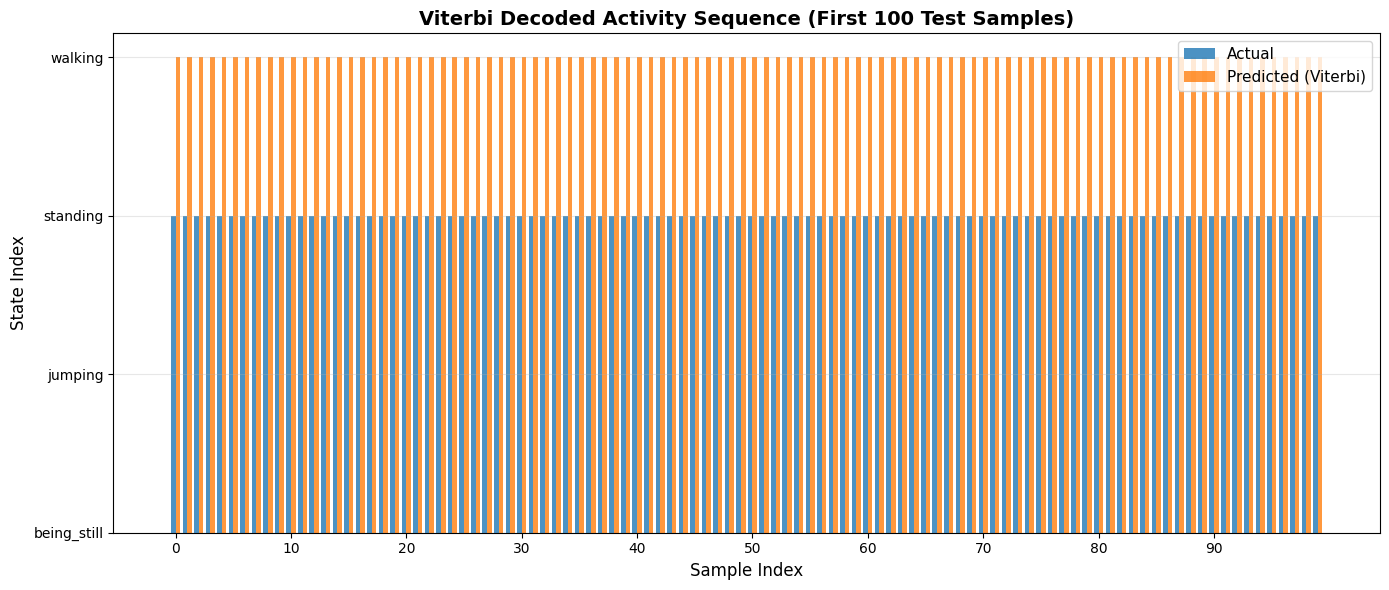

Viterbi decoded sequence plot saved as 'viterbi_decoded_sequence.png'.


In [105]:

fig, ax = plt.subplots(figsize=(14, 6))

test_window = 100
x_pos = np.arange(test_window)

if len(y_pred_test) == 0:
    ax.text(0.5, 0.5, 'No test data available to plot.', ha='center', va='center', fontsize=12)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    print("Skipped saving Viterbi plot because test set is empty.")
else:
    ax.bar(x_pos - 0.2, [STATE_TO_IDX[s] for s in y_test_labels[:test_window]], width=0.4, label='Actual', alpha=0.8)
    ax.bar(x_pos + 0.2, y_pred_test[:test_window], width=0.4, label='Predicted (Viterbi)', alpha=0.8)
    ax.set_xlabel('Sample Index', fontsize=12)
    ax.set_ylabel('State Index', fontsize=12)
    ax.set_title('Viterbi Decoded Activity Sequence (First 100 Test Samples)', fontsize=14, fontweight='bold')
    ax.set_xticks(np.arange(0, test_window, 10))
    ax.set_yticks(range(N_STATES))
    ax.set_yticklabels(STATES)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('viterbi_decoded_sequence.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Viterbi decoded sequence plot saved as 'viterbi_decoded_sequence.png'.")

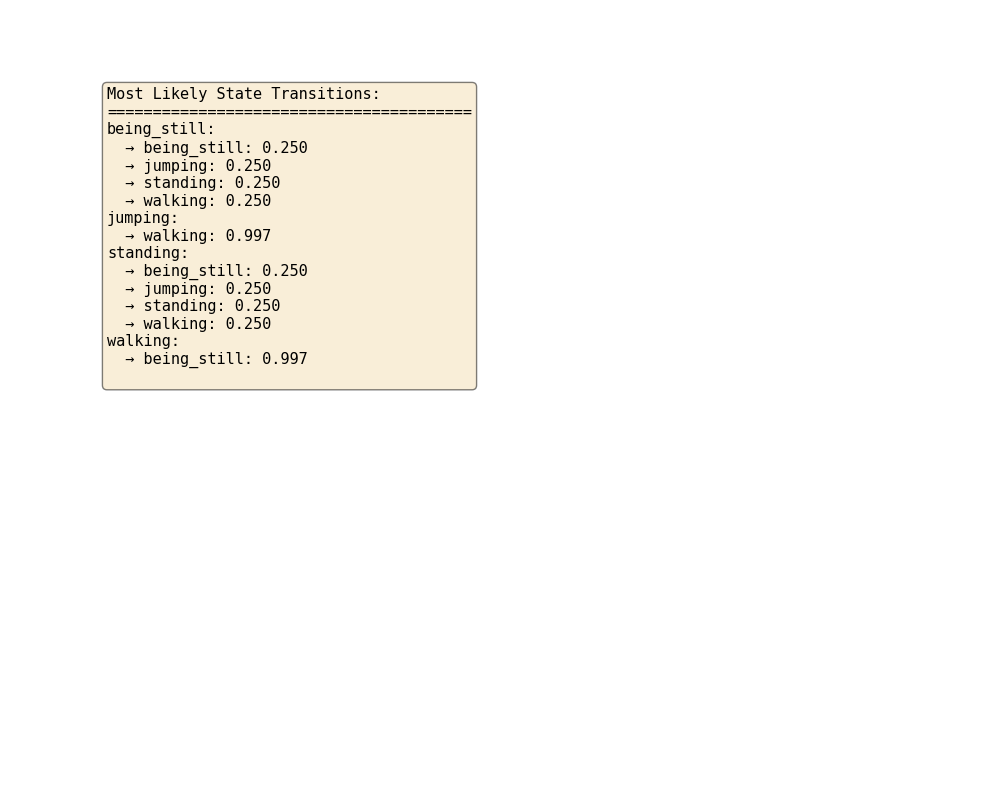

Transition flow diagram saved as 'transition_flow.png'.


In [106]:

threshold = 0.1  

fig, ax = plt.subplots(figsize=(10, 8))

transitions_text = 'Most Likely State Transitions:\n' + '='*40 + '\n'
for i, from_state in enumerate(STATES):
    transitions_text += f'{from_state}:\n'
    for j, to_state in enumerate(STATES):
        prob = A_learned[i, j]
        if prob > threshold:
            transitions_text += f'  → {to_state}: {prob:.3f}\n'

ax.text(0.1, 0.9, transitions_text, transform=ax.transAxes, fontsize=11, verticalalignment='top',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.axis('off')
plt.tight_layout()
plt.savefig('transition_flow.png', dpi=150, bbox_inches='tight')
plt.show()
print("Transition flow diagram saved as 'transition_flow.png'.")